In [1]:
import numpy as np
import joblib
import tensorflow as tf
import matplotlib.pyplot as plt

# Import our custom modules
from generative_finance.models import (
    build_autoencoder, 
    build_generator, 
    build_discriminator
)
from generative_finance.training import TimeGANTrainer

/Users/sankalpyadav/Desktop/QuantProjects/GAN-Transformers-Synthetic-Data/.venv/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


## 1. Configuration

In [2]:
# Select which stock to train on
TICKER = 'AAPL'

# Model Hyperparameters
SEQ_LEN = 24
FEATURE_DIM = 1 # We are using a univariate time series (Adj Close price)
LATENT_DIM = 48 # Dimensionality of the latent space
NUM_LAYERS = 2  # Number of GRU layers in the models

# Training Hyperparameters
EPOCHS = 500 # Total number of training epochs
BATCH_SIZE = 128
LEARNING_RATES = {
    'autoencoder': 0.001,
    'supervisor': 0.001,
    'gan': {
        'generator': 0.001,      # Keep generator's LR high
        'discriminator': 0.00001 # Decrease discriminator's LR further
    }
}

print("--- Configuration Loaded ---")
print(f"Target Ticker: {TICKER}")
print(f"Latent Dimension: {LATENT_DIM}")
print(f"Epochs: {EPOCHS}")

--- Configuration Loaded ---
Target Ticker: AAPL
Latent Dimension: 48
Epochs: 500


## 2. Load Pre-processed Data

In [3]:
try:
    data_path = f'data/processed/{TICKER}_data.npy'
    scaler_path = f'data/processed/{TICKER}_scaler.joblib'
    
    # Load the numpy array and the scaler
    data = np.load(data_path)
    scaler = joblib.load(scaler_path)
    
    # FIX: Convert data to float32 to match TensorFlow's default type
    data = data.astype('float32')
    
    print(f"\n--- Data Loaded Successfully ---")
    print(f"Data shape: {data.shape}")
    print(f"Data type: {data.dtype}") # Should now report float32
    
except FileNotFoundError:
    print(f"Error: Data for ticker {TICKER} not found. Please run the data preparation notebook first.")
    exit()



--- Data Loaded Successfully ---
Data shape: (2614, 24, 1)
Data type: float32


## 3. Build the TimeGAN Models

In [4]:
encoder, recovery = build_autoencoder(SEQ_LEN, LATENT_DIM, FEATURE_DIM)
generator = build_generator(SEQ_LEN, LATENT_DIM)
discriminator = build_discriminator(SEQ_LEN, LATENT_DIM)

models = {
    'encoder': encoder,
    'recovery': recovery,
    'generator': generator,
    'discriminator': discriminator
}

print("\n--- Models Built Successfully ---")
models['discriminator'].summary()



--- Models Built Successfully ---


/Users/sankalpyadav/Desktop/QuantProjects/GAN-Transformers-Synthetic-Data/.venv/lib/python3.9/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/Users/sankalpyadav/Desktop/QuantProjects/GAN-Transformers-Synthetic-Data/.venv/lib/python3.9/site-packages/keras/src/layers/regularization/gaussian_noise.py:29: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "Discriminator"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gaussian_noise (GaussianNoise)  │ (None, 24, 48)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_6 (GRU)                     │ (None, 24, 48)         │        14,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_7 (GRU)                     │ (None, 48)             │        14,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            49 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 28,273 (110.44 KB)

 Trainable params: 28,273 (110.44 KB)

 Non-trainable params: 0 (0.00 B)

## 4. Initialize and Run the Trainer

In [5]:
trainer = TimeGANTrainer(
    models=models,
    latent_dim=LATENT_DIM,
    learning_rates=LEARNING_RATES
)

print("\n--- Starting Model Training ---")
# This will begin the epoch-by-epoch training process
trainer.train(
    data=data,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    critic_steps=5 # Use 'critic_steps' instead
)

print("\n--- Training Complete ---")


--- Starting Model Training ---


2025-07-06 12:44:41.277338: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch: 0, D_loss: 4.4569, G_loss: -0.0517, E_loss: 1.1321, G_loss_S: 0.1154


2025-07-06 12:44:45.081321: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2025-07-06 12:44:53.804232: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2025-07-06 12:45:12.595609: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch: 10, D_loss: 0.2017, G_loss: -0.4121, E_loss: 0.1804, G_loss_S: 0.0127


2025-07-06 12:45:51.434458: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch: 20, D_loss: -1.3854, G_loss: 0.1849, E_loss: 0.1198, G_loss_S: 0.0126
Epoch: 30, D_loss: -1.8834, G_loss: 0.6848, E_loss: 0.1144, G_loss_S: 0.0110


2025-07-06 12:47:08.166686: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch: 40, D_loss: -2.7496, G_loss: 1.3684, E_loss: 0.1022, G_loss_S: 0.0114
Epoch: 50, D_loss: -3.0083, G_loss: 2.1309, E_loss: 0.0723, G_loss_S: 0.0104
Epoch: 60, D_loss: -2.6874, G_loss: 2.1293, E_loss: 0.0723, G_loss_S: 0.0098


2025-07-06 12:49:43.875598: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch: 70, D_loss: -3.1743, G_loss: 2.4200, E_loss: 0.0696, G_loss_S: 0.0094
Epoch: 80, D_loss: -2.9246, G_loss: 2.5793, E_loss: 0.0797, G_loss_S: 0.0082
Epoch: 90, D_loss: -3.0840, G_loss: 2.6364, E_loss: 0.0432, G_loss_S: 0.0088
Epoch: 100, D_loss: -3.0443, G_loss: 2.6566, E_loss: 0.0594, G_loss_S: 0.0084
Epoch: 110, D_loss: -2.2127, G_loss: 2.6150, E_loss: 0.1089, G_loss_S: 0.0063
Epoch: 120, D_loss: -3.1375, G_loss: 2.6333, E_loss: 0.0565, G_loss_S: 0.0086


2025-07-06 12:54:48.558963: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch: 130, D_loss: -2.6414, G_loss: 2.7169, E_loss: 0.0546, G_loss_S: 0.0067
Epoch: 140, D_loss: -3.0673, G_loss: 2.7214, E_loss: 0.0547, G_loss_S: 0.0083
Epoch: 150, D_loss: -2.9691, G_loss: 2.8133, E_loss: 0.0634, G_loss_S: 0.0069
Epoch: 160, D_loss: -2.2824, G_loss: 2.8413, E_loss: 0.0314, G_loss_S: 0.0057
Epoch: 170, D_loss: -2.6093, G_loss: 2.7926, E_loss: 0.0438, G_loss_S: 0.0068
Epoch: 180, D_loss: -2.9023, G_loss: 2.7886, E_loss: 0.0531, G_loss_S: 0.0079
Epoch: 190, D_loss: -3.3690, G_loss: 2.8244, E_loss: 0.0640, G_loss_S: 0.0078
Epoch: 200, D_loss: -3.0201, G_loss: 2.8390, E_loss: 0.0506, G_loss_S: 0.0067
Epoch: 210, D_loss: -2.9706, G_loss: 2.8938, E_loss: 0.0485, G_loss_S: 0.0067
Epoch: 220, D_loss: -3.1676, G_loss: 2.8697, E_loss: 0.0873, G_loss_S: 0.0078
Epoch: 230, D_loss: -3.0565, G_loss: 2.9448, E_loss: 0.0444, G_loss_S: 0.0069
Epoch: 240, D_loss: -2.7996, G_loss: 2.8704, E_loss: 0.0583, G_loss_S: 0.0064
Epoch: 250, D_loss: -2.5656, G_loss: 2.8756, E_loss: 0.0319, G_l

2025-07-06 13:04:59.530836: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch: 260, D_loss: -2.6081, G_loss: 2.9226, E_loss: 0.0663, G_loss_S: 0.0054
Epoch: 270, D_loss: -2.9325, G_loss: 2.8778, E_loss: 0.0449, G_loss_S: 0.0066
Epoch: 280, D_loss: -2.8946, G_loss: 2.9546, E_loss: 0.0523, G_loss_S: 0.0065
Epoch: 290, D_loss: -3.0076, G_loss: 2.8567, E_loss: 0.0305, G_loss_S: 0.0065
Epoch: 300, D_loss: -2.8380, G_loss: 2.8769, E_loss: 0.0383, G_loss_S: 0.0064
Epoch: 310, D_loss: -3.0220, G_loss: 2.9489, E_loss: 0.0390, G_loss_S: 0.0068
Epoch: 320, D_loss: -3.2068, G_loss: 2.8887, E_loss: 0.0204, G_loss_S: 0.0068
Epoch: 330, D_loss: -2.9334, G_loss: 2.9426, E_loss: 0.0372, G_loss_S: 0.0063
Epoch: 340, D_loss: -3.0434, G_loss: 2.9805, E_loss: 0.0481, G_loss_S: 0.0072
Epoch: 350, D_loss: -2.9807, G_loss: 3.0011, E_loss: 0.0357, G_loss_S: 0.0066
Epoch: 360, D_loss: -2.8093, G_loss: 3.0505, E_loss: 0.0340, G_loss_S: 0.0060
Epoch: 370, D_loss: -2.9348, G_loss: 3.1435, E_loss: 0.0390, G_loss_S: 0.0065
Epoch: 380, D_loss: -3.0529, G_loss: 3.1475, E_loss: 0.0390, G_l


## 5. Generate Synthetic Data (Post-Training)

In [6]:
print("\n--- Starting Synthetic Data Generation ---")

# Define the number of synthetic samples to generate
num_samples_to_generate = 500

# 1. Generate random noise sequences
random_noise = tf.random.normal(shape=(num_samples_to_generate, SEQ_LEN, LATENT_DIM))

# 2. Use the generator to create synthetic sequences in the latent space
generated_data_latent = models['generator'].predict(random_noise)
print(f"Shape of generated latent data: {generated_data_latent.shape}")

# 3. Use the recovery model to convert from latent space to real (scaled) space
# This is the crucial missing step.
generated_data_scaled = models['recovery'].predict(generated_data_latent)
print(f"Shape of recovered (scaled) data: {generated_data_scaled.shape}")

# 4. Reshape the data for the scaler
# The scaler expects a 2D array: (total_timesteps, features)
generated_data_reshaped = generated_data_scaled.reshape(-1, FEATURE_DIM)

# 5. Inverse transform the data to get the real price scale
synthetic_data = scaler.inverse_transform(generated_data_reshaped)

# 6. Reshape the final data back into sequences
synthetic_data = synthetic_data.reshape(num_samples_to_generate, SEQ_LEN, FEATURE_DIM)

print("\n--- Synthetic Data Generation Complete ---")
print(f"Final shape of synthetic data: {synthetic_data.shape}")


--- Starting Synthetic Data Generation ---
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
Shape of generated latent data: (500, 24, 48)
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
Shape of recovered (scaled) data: (500, 24, 1)

--- Synthetic Data Generation Complete ---
Final shape of synthetic data: (500, 24, 1)


## 6. Plots

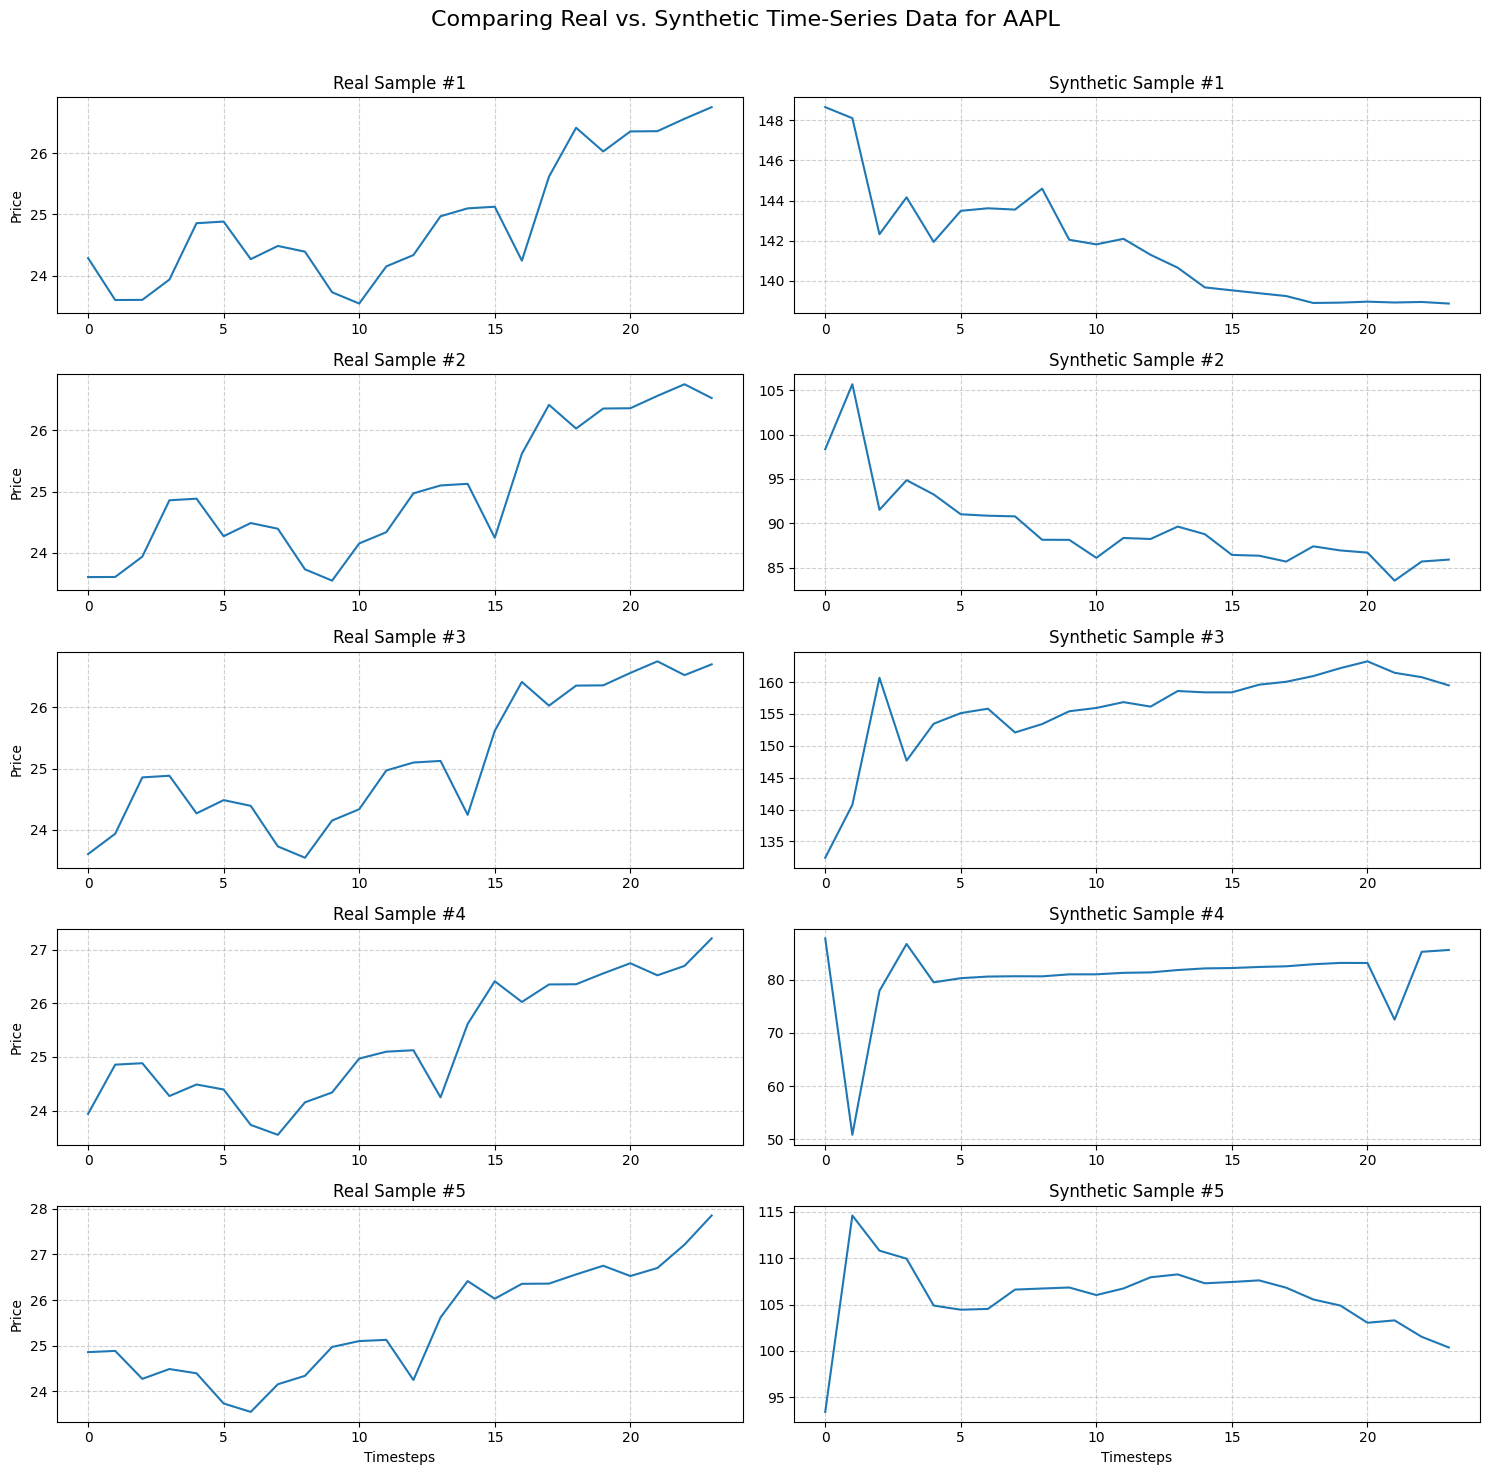

In [7]:
# -- 1. Configuration --
# Number of sample sequences to plot
num_to_plot = 5

# -- 2. Select Real and Synthetic Samples --
# Select the first few synthetic samples
synthetic_samples = synthetic_data[:num_to_plot]

# Select the first few real samples from the original pre-processed data
real_samples_scaled = data[:num_to_plot]

# -- 3. Inverse Transform the Real Samples to Original Price Scale --
# Reshape for the scaler
real_samples_reshaped = real_samples_scaled.reshape(-1, FEATURE_DIM)

# Inverse transform
real_samples_unscaled = scaler.inverse_transform(real_samples_reshaped)

# Reshape back to sequences
real_samples = real_samples_unscaled.reshape(num_to_plot, SEQ_LEN, FEATURE_DIM)


# -- 4. Create the Plots --
fig, axes = plt.subplots(nrows=num_to_plot, ncols=2, figsize=(15, num_to_plot * 3))
fig.suptitle(f'Comparing Real vs. Synthetic Time-Series Data for {TICKER}', fontsize=16)

for i in range(num_to_plot):
    # Plot Real Data
    axes[i, 0].plot(real_samples[i])
    axes[i, 0].set_title(f'Real Sample #{i + 1}')
    axes[i, 0].set_ylabel('Price')
    axes[i, 0].grid(True, linestyle='--', alpha=0.6)
    
    # Plot Synthetic Data
    axes[i, 1].plot(synthetic_samples[i])
    axes[i, 1].set_title(f'Synthetic Sample #{i + 1}')
    axes[i, 1].grid(True, linestyle='--', alpha=0.6)

# Add x-axis labels to the last row only
axes[-1, 0].set_xlabel('Timesteps')
axes[-1, 1].set_xlabel('Timesteps')

plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.show()